In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
import sys, os

sys.path.append(os.path.abspath('../'))
print(sys.path)

['/sise/home/alonshp/CellProfiling-research/code/alon', '/home/alonshp/.conda/envs/tf-env/lib/python38.zip', '/home/alonshp/.conda/envs/tf-env/lib/python3.8', '/home/alonshp/.conda/envs/tf-env/lib/python3.8/lib-dynload', '', '/home/alonshp/.conda/envs/tf-env/lib/python3.8/site-packages', '/sise/home/alonshp/CellProfiling-research/code']


In [6]:
from percantage_replicates_utils import *
from hit_finding.constants import *
from hit_finding.metrics import *

In [7]:
pd.get_option("display.max_rows",100)
'''/home/alonshp/.conda/envs/tf-env/bin/python'''

err_fld = f'/storage/users/g-and-n/tabular_models_results/30000/results/errors/'
files = [(int(f.name.split('.')[0]), f.name) for f in os.scandir(err_fld) if f.name.endswith('.csv')]

if 'alonshp' in os.path.abspath('../code'):
    userid = 'alonshp'
else:
    userid = 'naorko'
# userid = 'alonshp'
# res_dir = os.path.abspath('../../../../sise/assafzar-group/g-and-n/')
# sys.path.append(res_dir)
if userid == 'alonshp':
    res_dir = os.path.abspath('../../../../../assafzar-group/g-and-n/')
    # res_dir = os.path.abspath('../../../../../../assafzar-group/g-and-n/')
    sys.path.append(res_dir)
else:
    sys.path.append(os.path.abspath('../code'))

if userid == 'alonshp':
    res_pth = os.path.join(res_dir, 'tabular_models_results/30000/results/z_scores/pure')
    plates = os.listdir(os.path.join(res_pth, 'err'))
else:
    res_pth = '../../../tabular_models_results/30000/results/z_scores/frac_score'
    t = 4
    # plates = os.listdir(os.path.join(res_pth, str(4)))
    res_path_thresh = os.path.join(res_pth, str(t))
    plates = os.listdir(os.path.join(res_pth, str(t)))


debug=True
print(len(files))
if debug:
    files = files[0:40]
num_plates = len(files)
print(len(files))

406
40


# Produce null disribution

In [6]:

cpd_map = pd.concat([load_pure_zscores(p_name, raw=False) for _, p_name in files])
cpd_raw = pd.concat([load_pure_zscores(p_name, raw=True) for _, p_name in files])
cpd_raw1to1 = pd.concat([load_pure_zscores(p_name, raw=True, inter_channel=False) for _, p_name in files])

cpd_raw.drop(columns=[c for c in cpd_raw.columns if c not in cpd_map.columns], inplace=True)

print(cpd_map.shape, cpd_raw.shape, cpd_raw1to1.shape)


cpd_map_trt = cpd_map.query('Metadata_ASSAY_WELL_ROLE == "treated"')
cpd_raw_trt = cpd_raw.query('Metadata_ASSAY_WELL_ROLE == "treated"')
cpd_raw1to1_trt = cpd_raw1to1.query('Metadata_ASSAY_WELL_ROLE == "treated"')

cpd_map_ctl = cpd_map.query('Metadata_ASSAY_WELL_ROLE == "mock"')
cpd_raw_ctl = cpd_raw.query('Metadata_ASSAY_WELL_ROLE == "mock"')
cpd_raw1to1_ctl = cpd_raw1to1.query('Metadata_ASSAY_WELL_ROLE == "mock"')

field = 'ALL_map'


(14711, 414) (15351, 414) (14711, 414)


In [7]:
cpd_map_trt.index.get_level_values(2).value_counts().value_counts()

4    2554
3     642
1     641
2       2
Name: Metadata_broad_sample, dtype: int64

In [8]:
def get_replicates_score(cpd_df, fields=None):

    if not fields:
        fields = cpd_df.columns

    replicates_df, cpds = get_duplicate_replicates(cpd_df,min_num_reps=3)
    #     print(replicates.index.get_level_values(2).value_counts().value_counts())
    cpds_score_df = get_median_score(cpds, replicates_df[fields])

    return cpds_score_df


def get_null_distribution_replicates(
        all_replicates,
        cpds,
        rand_num=1000
):
    """
    This function returns a null distribution dictionary, with no_of_replicates(replicate class)
    as the keys and 1000 lists of randomly selected replicate combinations as the values
    for each no_of_replicates class per DOSE(1-6)
    """
    random.seed(1903)
    # null_distribution_reps = defaultdict(list)
    null_distribution_reps = {}
    # for dose in dose_list:
    #     for replicate_class in cpd_replicate_class_dict:
    for replicate in tqdm(cpds):
            # replicates_ids = cpd_replicate_class_dict[replicate_class][dose - 1]
            # a = cpds_score_df_trt[cpds_score_df_trt.index == cpds_score_df_trt.index[0]]

            replicate_list = []
            for idx in range(rand_num):
                start_again = True
                while (start_again):
                    rand_cpds = get_random_replicates(
                        cpds,
                        # all_replicates,
                        3,
                        replicate
                    )
                    # print(rand_cpds)
                    if rand_cpds not in replicate_list:
                        start_again = False
                    # print(rand_cpds)
                replicate_list.append(rand_cpds)
            # if replicate not in null_distribution_reps:
            # print(replicate_list)
            # null_distribution_reps[replicate].append(replicate_list)
            null_distribution_reps[replicate] = replicate_list
            # print(null_distribution_reps[replicate])
            # else:
            #     null_distribution_reps[replicate] += [replicate_list]
    # print(null_distribution_reps)
    return null_distribution_reps


In [8]:
# cpds_med_score = {}
cpds_med_score = {f'{m}_{t}': get_replicates_score(eval(f'cpd_{m}_{t}'))
                  for m in ['map', 'raw', 'raw1to1']
                  for t in ['trt', 'ctl']
                 }

cpds_score_df_trt = pd.DataFrame({k[:-4]: v for k, v in cpds_med_score.items() if 'trt' in k})
cpds_score_df_ctl = pd.DataFrame({k[:-4]: v for k, v in cpds_med_score.items() if 'ctl' in k})

display(cpds_score_df_trt)

,map,raw,raw1to1
BRD-K18250272-003-03-7,-0.015456,0.197320,-0.015803
BRD-K18316707-001-01-9,0.244602,0.471340,0.116752
BRD-K18438502-001-02-6,-0.039600,0.068213,-0.098543
BRD-K18550767-001-02-8,0.241033,0.348538,0.281212
BRD-K18574842-323-03-3,0.270368,0.392039,0.151177
...,...,...,...
BRD-K99100679-001-01-3,0.102403,-0.003396,0.107161
BRD-K99116119-001-01-7,0.083202,0.127814,-0.020365
BRD-K99702099-001-02-6,-0.077788,0.024508,-0.031276
BRD-K99800590-001-01-4,0.264974,0.384393,0.224088


In [9]:
from tqdm import tqdm
def get_null_distribution_replicates(
        all_replicates,
        cpds,
        rand_num=1000,
        num_reps_in_rand=4
):
    """
    This function returns a null distribution dictionary, with no_of_replicates(replicate class)
    as the keys and 1000 lists of randomly selected replicate combinations as the values
    for each no_of_replicates class per DOSE(1-6)
    """
    random.seed(1903)
    # null_distribution_reps = defaultdict(list)
    null_distribution_reps = {}
    # for dose in dose_list:
    #     for replicate_class in cpd_replicate_class_dict:
    for replicate in tqdm(cpds):
            # replicates_ids = cpd_replicate_class_dict[replicate_class][dose - 1]
            # a = cpds_score_df_trt[cpds_score_df_trt.index == cpds_score_df_trt.index[0]]

            replicate_list = []
            for idx in range(rand_num):
                start_again = True
                while (start_again):
                    rand_cpds = get_random_replicates(
                        cpds,
                        # all_replicates,
                        num_reps_in_rand,
                        replicate
                    )
                    # print(rand_cpds)
                    if rand_cpds not in replicate_list:
                        start_again = False
                    # print(rand_cpds)
                replicate_list.append(rand_cpds)
            # if replicate not in null_distribution_reps:
            # print(replicate_list)
            # null_distribution_reps[replicate].append(replicate_list)
            null_distribution_reps[replicate] = replicate_list
            # print(null_distribution_reps[replicate])
            # else:
            #     null_distribution_reps[replicate] += [replicate_list]
    # print(null_distribution_reps)
    return null_distribution_reps

def get_random_replicates(all_replicates, no_of_replicates, replicate):
    """
    This function return a list of random replicates that are not of the same compounds
    or found in the current cpd's size list
    """
    while (True):
        random_replicates = random.sample(set(all_replicates), no_of_replicates)
        # random_replicates = list(all_replicates.sample(no_of_replicates).index.get_level_values(2))
        # print(random_replicates)
        if not (any(rep in replicate for rep in random_replicates)):
                # & (check_similar_replicates(random_replicates, dose, cpd_replicate_dict))):
            break
        
    return random_replicates

In [10]:

replicates_df, cpds = get_duplicate_replicates(cpd_map_trt,min_num_reps=4)
null_distribution_replicates = get_null_distribution_replicates(replicates_df, cpds, rand_num=1000)

100%|██████████| 2554/2554 [18:06<00:00,  2.35it/s]


In [11]:
duplicate_replicates = assert_null_distribution(null_distribution_replicates)
duplicate_replicates ## no replicates

{}

## Calculate Median Scores P-values

In [1]:
null_distribution_medians = {}
null_distribution_medians['map'] = get_null_dist_median_scores(null_distribution_replicates, cpd_map_trt)
null_distribution_medians['raw1to1'] = get_null_dist_median_scores(null_distribution_replicates, cpd_raw1to1_trt)


NameError: name 'get_null_dist_median_scores' is not defined

In [13]:
null_distribution_medians['raw'] = get_null_dist_median_scores(null_distribution_replicates, cpd_raw_trt)
len(null_distribution_medians['map'][cpds[0]])

100%|██████████| 2554/2554 [1:52:47<00:00,  2.65s/it]


1000

In [14]:
df_null_p_vals = pd.DataFrame([])
methods=cpds_score_df_trt.columns
for method in ['map','raw','raw1to1']:
    # null_distribution_medians = get_null_dist_median_scores(null_distribution_replicates, cpds_score_df_trt,method=method)
    null_p_vals = get_moa_p_vals(null_distribution_medians[method], cpds_score_df_trt, method=method)
    method_df_null_p_vals = pd.DataFrame.from_dict(null_p_vals,orient='index',columns=[method])
    if len(df_null_p_vals)>0:
        df_null_p_vals = df_null_p_vals.join(method_df_null_p_vals)
    else:
        df_null_p_vals = method_df_null_p_vals.copy()
    
    # cpds_score_df_trt = cpds_score_df_trt.join(df_null_p_vals)

display(df_null_p_vals)

In [16]:
medians = cpds_score_df_trt[['map','raw','raw1to1']].melt(var_name=["method"],value_name='median_score',ignore_index=False).reset_index()
p_vals = df_null_p_vals[['map','raw','raw1to1']].melt(var_name=["method"],value_name='p_val',ignore_index=False).reset_index()
cpds_score_df_trt.to_csv(f'cpds_score_df_trt_{num_plates}.csv')
df_null_p_vals.to_csv(f'df_null_p_vals_{num_plates}.csv')
# a = pd.merge(medians,p_vals, left_on=['index','median_score'], right_on=['index','p_val'])
percantage_replicating_df = pd.merge(medians,p_vals, on=['index','method'])
percantage_replicating_df.to_csv(f'percentage_replicating_{num_plates}.csv') #, index=False, sep="\t")
    
    

# Load results (PR and SS)
based on https://github.com/broadinstitute/lincs-profiling-complementarity/blob/master/1.Data-exploration/Profiles_level4/cell_painting/9.cellpainting-percent-replicating-subsampled-and-nonspherized.ipynb



In [1]:
import re
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
sns.set_style("darkgrid")
sns.set_context("talk")

In [129]:
percantage_replicating_df = pd.read_csv('percentage_replicating_40.csv')
percantage_replicating_df.method.value_counts()
# cpd_map_trt.head()

df_null_p_vals= pd.read_csv(f'df_null_p_vals_{num_plates}.csv')
df_null_p_vals.rename( columns={'Unnamed: 0':'Metadata_broad_sample'}, inplace=True )
df_null_p_vals.head()
# df_null_p_vals.isna().sum()

# df_null_p_vals['map1'] = np.where(df_null_p_vals['map']<0.001,0.001,df_null_p_vals['map'])
# df_null_p_vals['raw1'] = np.where(df_null_p_vals['raw']<0.001,0.001,df_null_p_vals['raw'])
# df_null_p_vals['raw1to11'] = np.where(df_null_p_vals['raw1to1']<0,0.001,df_null_p_vals['raw1to1'])
# df_null_p_vals.isna().sum()


,Metadata_broad_sample,map,raw,raw1to1
0,BRD-A00100033-001-04-8,0.002,0.003,0.000
1,BRD-A00267231-001-01-1,0.031,0.000,0.005
2,BRD-A00327403-103-01-9,0.046,0.022,0.016
3,BRD-A00520476-001-03-3,0.141,0.087,0.058
4,BRD-A00827783-001-04-8,0.079,0.799,0.054


In [3]:
# load SS results
map_res = pd.read_csv(f'/storage/users/g-and-n/tabular_models_results/30000/results/z_scores/ss_mas/map.csv', index_col=[0])
raw_res = pd.read_csv(f'/storage/users/g-and-n/tabular_models_results/30000/results/z_scores/ss_mas/raw.csv', index_col=[0])
raw1to1_res = pd.read_csv(f'/storage/users/g-and-n/tabular_models_results/30000/results/z_scores/ss_mas/raw1to1.csv', index_col=[0])

In [42]:
# merge map and raw
map_raw = pd.merge(map_res, raw_res,left_index=True, right_index=True, suffixes=('_map','_raw'))

# merge both with raw1to1
raw1to1_res=raw1to1_res.add_suffix('_raw1to1')
all_ss = pd.merge(map_raw,raw1to1_res,left_index=True, right_index=True)

# keep only 'All' results
all_ss = all_ss.filter(regex='ALL_')
all_ss.head()

,ALL_Med_Corr_map,ALL_SS_2_map,ALL_MAS_2_map,ALL_SS_3_map,ALL_MAS_3_map,ALL_SS_4_map,ALL_MAS_4_map,ALL_SS_5_map,ALL_MAS_5_map,ALL_SS_6_map,...,ALL_SS_16_raw1to1,ALL_MAS_16_raw1to1,ALL_SS_17_raw1to1,ALL_MAS_17_raw1to1,ALL_SS_18_raw1to1,ALL_MAS_18_raw1to1,ALL_SS_19_raw1to1,ALL_MAS_19_raw1to1,ALL_SS_20_raw1to1,ALL_MAS_20_raw1to1
Metadata_broad_sample,,,,,,,,,,,,,,,,,,,,,
BRD-A00037023-001-05-1,0.263927,113.750,0.269288,41.250,0.162164,13.500,0.092770,5.250,0.057852,3.50,...,0.000,0.000000,0.00,0.00000,0.000,0.000000,0.000,0.000000,0.000,0.000000
BRD-A00051892-001-05-0,0.209897,77.000,0.197582,22.250,0.106211,7.500,0.061664,2.500,0.035602,1.25,...,0.000,0.000000,0.00,0.00000,0.000,0.000000,0.000,0.000000,0.000,0.000000
BRD-A00100033-001-04-8,0.052868,202.125,0.160659,129.375,0.128535,86.375,0.105024,59.375,0.087076,43.75,...,1.875,0.015775,1.25,0.01288,0.875,0.010776,0.375,0.007055,0.375,0.007055
BRD-A00214921-001-04-2,0.027105,110.250,0.084960,32.000,0.045772,10.500,0.026219,4.250,0.016681,1.75,...,0.000,0.000000,0.00,0.00000,0.000,0.000000,0.000,0.000000,0.000,0.000000
BRD-A00250346-001-05-0,0.181629,111.000,0.220676,43.750,0.138542,17.250,0.086994,8.500,0.061066,4.50,...,0.000,0.000000,0.00,0.00000,0.000,0.000000,0.000,0.000000,0.000,0.000000


In [17]:
all_ss.head()

,ALL_Med_Corr_map,ALL_SS_2_map,ALL_MAS_2_map,ALL_SS_3_map,ALL_MAS_3_map,ALL_SS_4_map,ALL_MAS_4_map,ALL_SS_5_map,ALL_MAS_5_map,ALL_SS_6_map,...,ALL_SS_16,ALL_MAS_16,ALL_SS_17,ALL_MAS_17,ALL_SS_18,ALL_MAS_18,ALL_SS_19,ALL_MAS_19,ALL_SS_20,ALL_MAS_20
Metadata_broad_sample,,,,,,,,,,,,,,,,,,,,,
BRD-A00037023-001-05-1,0.263927,113.750,0.269288,41.250,0.162164,13.500,0.092770,5.250,0.057852,3.50,...,0.000,0.000000,0.00,0.00000,0.000,0.000000,0.000,0.000000,0.000,0.000000
BRD-A00051892-001-05-0,0.209897,77.000,0.197582,22.250,0.106211,7.500,0.061664,2.500,0.035602,1.25,...,0.000,0.000000,0.00,0.00000,0.000,0.000000,0.000,0.000000,0.000,0.000000
BRD-A00100033-001-04-8,0.052868,202.125,0.160659,129.375,0.128535,86.375,0.105024,59.375,0.087076,43.75,...,1.875,0.015775,1.25,0.01288,0.875,0.010776,0.375,0.007055,0.375,0.007055
BRD-A00214921-001-04-2,0.027105,110.250,0.084960,32.000,0.045772,10.500,0.026219,4.250,0.016681,1.75,...,0.000,0.000000,0.00,0.00000,0.000,0.000000,0.000,0.000000,0.000,0.000000
BRD-A00250346-001-05-0,0.181629,111.000,0.220676,43.750,0.138542,17.250,0.086994,8.500,0.061066,4.50,...,0.000,0.000000,0.00,0.00000,0.000,0.000000,0.000,0.000000,0.000,0.000000


In [51]:
methods = ['map','raw','raw1to1']
t = [2,4,6,8]
for m in methods:
    all_ss_t = all_ss.filter(regex=f'SS_{t}_{m}')
    all_ss_t.head()
    
# all_ss.columns
# all_ss_t.rename(columns={f'ALL_SS_{t}_map':'map', f'ALL_SS_{t}_raw':'raw', f'ALL_SS_{t}_raw1to1':'raw1to1'},inplace=True)
# all_ss_t.head()
# ( columns={'Unnamed: 0':'Metadata_broad_sample'}, inplace=True )

,ALL_SS_2_map,ALL_SS_4_map,ALL_SS_6_map,ALL_SS_8_map,ALL_SS_2_raw,ALL_SS_4_raw,ALL_SS_6_raw,ALL_SS_8_raw,ALL_SS_2_raw1to1,ALL_SS_4_raw1to1,ALL_SS_6_raw1to1,ALL_SS_8_raw1to1
Metadata_broad_sample,,,,,,,,,,,,
BRD-A00037023-001-05-1,113.750,13.500,3.50,1.00,161.75,31.000,1.00,0.25,90.25,18.000,3.750,1.50
BRD-A00051892-001-05-0,77.000,7.500,1.25,0.25,88.00,1.000,0.00,0.00,88.00,4.750,1.250,0.25
BRD-A00100033-001-04-8,202.125,86.375,43.75,25.25,277.50,155.875,68.25,25.25,196.25,75.375,30.375,14.50
BRD-A00214921-001-04-2,110.250,10.500,1.75,0.75,139.00,13.500,1.00,0.00,128.75,9.750,0.750,0.50
BRD-A00250346-001-05-0,111.000,17.250,4.50,1.50,159.00,26.750,1.50,0.25,128.50,27.500,6.250,2.25


In [131]:
# add fields of log p_vals 
df_null_p_vals['map'] = np.where(df_null_p_vals['map']<0.001,0.001,df_null_p_vals['map'])
df_null_p_vals['raw'] = np.where(df_null_p_vals['raw']<0.001,0.001,df_null_p_vals['raw'])
df_null_p_vals['raw1to1'] = np.where(df_null_p_vals['raw1to1']<0.001,0.001,df_null_p_vals['raw1to1'])
# df_null_p_vals['raw_log'] = - np.log10(df_null_p_vals['raw'])
# df_null_p_vals['raw1to1_log'] = - np.log10(df_null_p_vals['raw1to1'])

df_null_p_vals['map_log'] = - np.log10(df_null_p_vals['map'])
df_null_p_vals['raw_log'] = - np.log10(df_null_p_vals['raw'])
df_null_p_vals['raw1to1_log'] = - np.log10(df_null_p_vals['raw1to1'])
df_null_p_vals.isna().sum()
# df_null_p_vals['map_log-raw_log'] = df_null_p_vals['map_log']-df_null_p_vals['raw_log']
# df_null_p_vals['map_log-raw1to1_log'] = df_null_p_vals['map_log']-df_null_p_vals['raw1to1_log']

Metadata_broad_sample    0
map                      0
raw                      0
raw1to1                  0
map_log                  0
raw_log                  0
raw1to1_log              0
dtype: int64

In [134]:
df_null_p_vals.columns

Index(['Metadata_broad_sample', 'map', 'raw', 'raw1to1', 'map_log', 'raw_log',
       'raw1to1_log'],
      dtype='object')

In [136]:
percantage_replicating_df_non_melt = pd.merge(all_ss_t,df_null_p_vals, on=['Metadata_broad_sample'],suffixes=('_SS','_p_val'))
percantage_replicating_df_non_melt.head()
percantage_replicating_df_non_melt.isna().sum()

Metadata_broad_sample    0
ALL_SS_2_map             0
ALL_SS_4_map             0
ALL_SS_6_map             0
ALL_SS_8_map             0
ALL_SS_2_raw             0
ALL_SS_4_raw             0
ALL_SS_6_raw             0
ALL_SS_8_raw             0
ALL_SS_2_raw1to1         0
ALL_SS_4_raw1to1         0
ALL_SS_6_raw1to1         0
ALL_SS_8_raw1to1         0
map                      0
raw                      0
raw1to1                  0
map_log                  0
raw_log                  0
raw1to1_log              0
dtype: int64

In [79]:
# SS = all_ss_t.melt(var_name=["method"],value_name='SS',ignore_index=False).reset_index()
# SS.head()

# Plot results
based on https://github.com/broadinstitute/lincs-profiling-complementarity/blob/master/1.Data-exploration/Profiles_level4/cell_painting/9.cellpainting-percent-replicating-subsampled-and-nonspherized.ipynb



0.4667188723570869
0.4487079091620987
0.41268598277212215


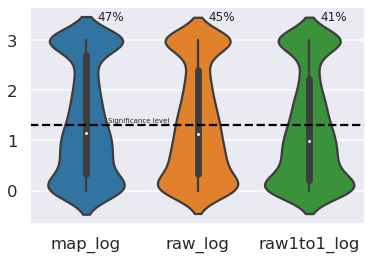

In [181]:
percantage_replicating_df_non_melt.head()

log_methods = [m +'_log' for m in methods]
# percantage_replicating_df_non_melt[log_methods].head()
fig = sns.violinplot(data=percantage_replicating_df_non_melt[log_methods])
log_val = -np.round(np.log10(0.05),5)
fig.axhline(log_val, ls='--', c='black')
# fig.legend(loc = 'lower right')
fig.text(0.2,0.05+log_val, "Significance level",fontsize=7)
for i, m in enumerate(log_methods):
        repre = percantage_replicating_df_non_melt[percantage_replicating_df_non_melt[m]>log_val][m].count()/len(percantage_replicating_df_non_melt)
        print(repre)
        fig.text(0.1+i, 3.4,str(int(np.round(repre,2)*100))+'%', fontsize=12) #add text
# [m +'_log' for m in methods]


309.7125
324.75624999999997
324.63124999999997
0.8828125
0.9765625
0.90625


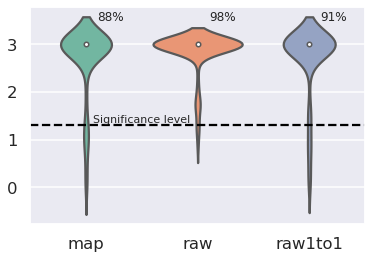

map        0
raw        0
raw1to1    0
dtype: int64

In [175]:
violin = {}
ts = [2,6]
t= 2
ind={}
# for ax, method in zip(dis_plt.axes.flat, methods):
        # ax.text(0.1, 300,'Reproducable replicates: '+str(int(np.round(repr_score[method],2)*100))+'%', fontsize=15)
for m in methods:
    quantile = percantage_replicating_df_non_melt[f'ALL_SS_{t}_{m}'].quantile(0.95)
    print(quantile)
    violin[m] = percantage_replicating_df_non_melt[percantage_replicating_df_non_melt[f'ALL_SS_{t}_{m}']>quantile][f'{m}_log'].values
    ind[m] = percantage_replicating_df_non_melt[percantage_replicating_df_non_melt[f'ALL_SS_{t}_{m}']>quantile][f'{m}_log'].index
    
violin_df = pd.DataFrame(violin)
fig=sns.violinplot(data=violin_df, palette="Set2")
log_val = -np.round(np.log10(0.05),5)
fig.axhline(log_val, ls='--', c='black')
# fig.legend(loc = 'lower right')
fig.text(0.06,0.05+log_val, "Significance level",fontsize=11)
for i, m in enumerate(methods):
        repre = violin_df[violin_df[m]>log_val][m].count()/len(violin_df)
        print(repre)
        fig.text(0.1+i, 3.5,str(int(np.round(repre,2)*100))+'%', fontsize=12) #add text
plt.show()
violin_df.isna().sum()
# violin_df.head()

152.29999999999927
130.19999999999996
172.81874999999985
112
128
0.875
125
128
0.9765625
116
128
0.90625


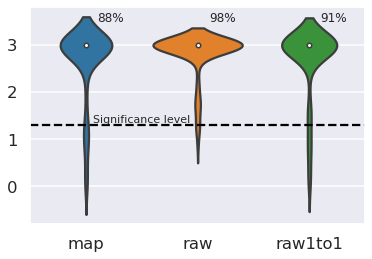

In [170]:
violin = {}
ind2={}
# ts = [2,6]
t = 8

# for ax, method in zip(dis_plt.axes.flat, methods):
#         ax.text(0.1, 300,'Reproducable replicates: '+str(int(np.round(repr_score[method],6)*100))+'%', fontsize=15)
for m in methods:
    quantile = percantage_replicating_df_non_melt[f'ALL_SS_{t}_{m}'].quantile(0.95)
    print(quantile)
    violin[m] = percantage_replicating_df_non_melt[percantage_replicating_df_non_melt[f'ALL_SS_{t}_{m}']>quantile][f'{m}_log'].values
    ind2[m] = percantage_replicating_df_non_melt[percantage_replicating_df_non_melt[f'ALL_SS_{t}_{m}']>quantile][f'{m}_log'].index
violin_df = pd.DataFrame(violin)
fig=sns.violinplot(data=violin_df)

log_val = -np.round(np.log10(0.05),5)
fig.axhline(log_val, ls='--', c='black')
# fig.legend(loc = 'lower right')
fig.text(0.06,0.05+log_val, "Significance level",fontsize=11)
for i, m in enumerate(methods):
        
        repre = violin_df[violin_df[m]>log_val][m].count()/len(violin_df)
        print(violin_df[violin_df[m]>log_val][m].count())
        print(len(violin_df))
        print(repre)
        fig.text(0.1+i, 3.5,str(int(np.round(repre,2)*100))+'%', fontsize=12) #add text
plt.show()


In [173]:
print(ind[m])
print(ind2[m])

Int64Index([ 116,  127,  133,  156,  162,  178,  238,  263,  281,  304,
            ...
            2337, 2339, 2365, 2375, 2393, 2406, 2446, 2464, 2478, 2481],
           dtype='int64', length=128)
Int64Index([ 116,  127,  133,  156,  162,  178,  238,  263,  281,  304,
            ...
            2327, 2337, 2339, 2375, 2393, 2406, 2446, 2464, 2478, 2481],
           dtype='int64', length=128)


/home/alonshp/.conda/envs/tf-env/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alonshp/.conda/envs/tf-env/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


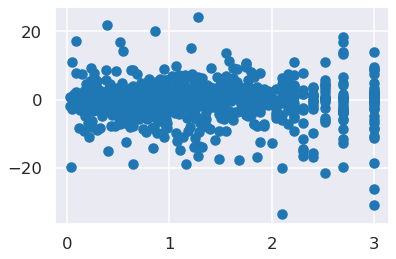

In [71]:
import matplotlib.pyplot as plt
plt.scatter(- np.log10(percantage_replicating_df_non_melt['map-raw1to1_p_val']), percantage_replicating_df_non_melt['map-raw1to1_SS'])

In [49]:
def rename_cols(df):
    'Rename columns from dose number to actual doses'
    
    df.sortname(columns= {'dose_1' : '0.04 uM', 'dose_2':'0.12 uM', 'dose_3':'0.37 uM',
                        'dose_4': '1.11 uM', 'dose_5':'3.33 uM', 'dose_6':'10 uM'}, inplace = True)
    return df

def melt_df(df, col_name):
    """
    This function returns a reformatted dataframe with 
    3 columns: cpd, dose number and dose_values(median score or p-value)
    """
    # df = df.melt(id_vars=['cpd', 'no_of_replicates'], var_name="dose", value_name=col_name)
    df = df.melt(id_vars=['cpd'], var_name="p_val", value_name=col_name)
    return df

def merge_p_median_vals(df_cpd_vals, df_null):
    """
    This function merge p_values and median scores 
    dataframes for each compound for all doses(1-6) 
    """
    df_p_vals = melt_df(df_null, 'p_values')
    df_cpd_vals = melt_df(df_cpd_vals, 'median_scores')
    df_cpd_vals['p_values'] = df_p_vals['p_values']
    return df_cpd_vals


In [50]:
def plot_p_vs_median(df, path, file_name,x_col="fraction_score"):
    
    """plot p_values vs median correlation scores for each compound for all doses (1-6)"""
    
    if not os.path.exists(path):
        os.mkdir(path)
    plt.rcParams.update({'font.size': 14})
    plt.figure(figsize=(12,8)) 
    plt.xlabel("Median scores of pairwise correlation btw cpds")
    plt.ylabel("Non-parametric P-values")
    plt.title("P-values vs median scores for compound replicates")
    # fig = sns.scatterplot(data=df, x="median_scores", y="p_values", hue="dose", 
    #                       style="dose", palette = "viridis")
    fig = sns.scatterplot(data=df, x=x_col, y="p_val", hue="method", 
                      style="method", palette = "viridis",alpha=0.5)

    fig.axhline(0.05, ls='--', c='black')
    fig.legend(loc = 'upper right')
    fig.text(-0.18,0.07, "Significance level (0.05)")
    plt.savefig(os.path.join(path, file_name))
    plt.show()

In [51]:
percantage_replicating_df[percantage_replicating_df['Metadata_broad_sample']=='BRD-K18250272-003-03-7']
# percantage_replicating_df.columns

,Metadata_broad_sample,method,SS,p_val
1036,BRD-K18250272-003-03-7,map,86.250,0.882
3590,BRD-K18250272-003-03-7,raw,57.125,0.140
6144,BRD-K18250272-003-03-7,raw1to1,71.500,0.893


ValueError: Could not interpret value `median_score` for parameter `x`

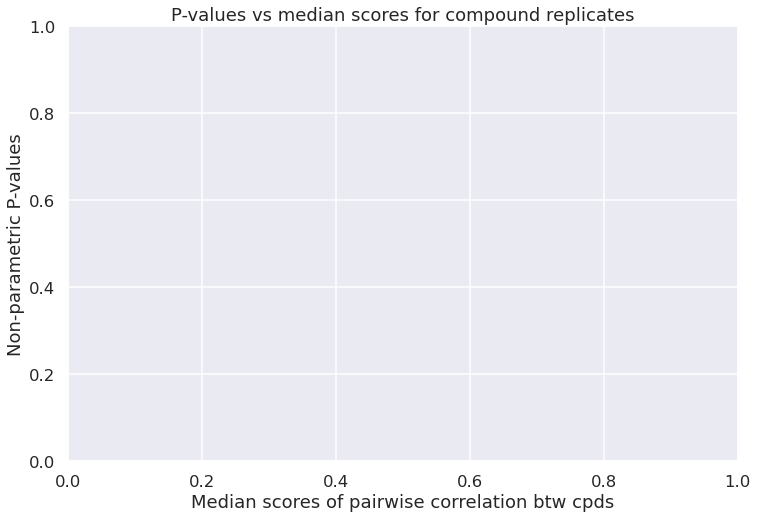

In [114]:
# percantage_replicating_df = percantage_replicating_df[percantage_replicating_df['method']!='raw1to1']

plot_p_vs_median(percantage_replicating_df,'cellpainting_figures', 'p_vs_median.png',x_col="median_score")
plot_p_vs_median(percantage_replicating_df,'cellpainting_figures', 'p_vs_fraction.png', x_col="fraction_score")

In [115]:
def plot_p_vs_median(df, path, file_name,x_col="fraction_score"):
    
    """plot p_values vs median correlation scores for each compound for all doses (1-6)"""
    
    if not os.path.exists(path):
        os.mkdir(path)
    plt.rcParams.update({'font.size': 14})
    plt.figure(figsize=(12,8)) 
    plt.xlabel(f"{x_col} scores of pairwise correlation btw cpds")
    plt.ylabel("Non-parametric -log10 P-values")
    plt.title(f"P-values vs {x_col} scores for compound replicates")
    # fig = sns.scatterplot(data=df, x="median_scores", y="p_values", hue="dose", 
    #                       style="dose", palette = "viridis")
    fig = sns.scatterplot(data=df, x=x_col, y="log10_p_val", hue="method", 
                      style="method", palette = "viridis",alpha=0.5)
    
    
    log_val = -np.round(np.log10(0.05),5)
    fig.axhline(log_val, ls='--', c='black')
    fig.legend(loc = 'lower right')
    if x_col == 'fraction_score':
        fig.text(0.2,0.03+log_val, "Significance level: "+str(log_val))
    else:
        fig.text(-0.5,0.03+log_val, "Significance level: "+str(log_val))
    plt.savefig(os.path.join(path, file_name))
    plt.show()
    


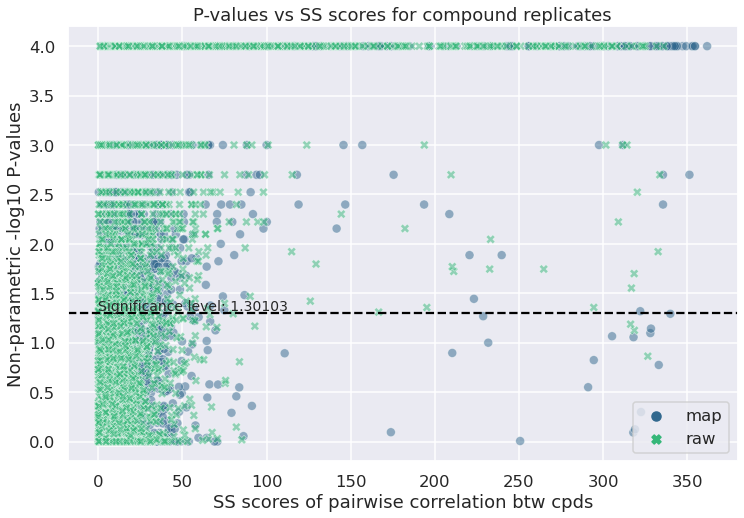

map    2554
raw    2554
Name: method, dtype: int64

In [116]:
row_indices = percantage_replicating_df['p_val']<0.0001
percantage_replicating_df.loc[row_indices,'p_val']=0.0001
percantage_replicating_df['log10_p_val'] = - np.log10(percantage_replicating_df['p_val'])

plot_p_vs_median(percantage_replicating_df,'cellpainting_figures', 'p_vs_ss_log.png',x_col="SS")
# plot_p_vs_median(percantage_replicating_df,'cellpainting_figures', 'p_vs_fraction_log.png', x_col="fraction_score")
# plot_p_vs_median(percantage_replicating_df, 'cellpainting_figures', 'p_vs_median_log.png')
percantage_replicating_df.method.value_counts()

In [117]:
def plot_score_distribution(df, title, path, file_name, x='p_val'):
    
    if not os.path.exists(path):
        os.mkdir(path)
        
    dis_plt = sns.displot(df, x=x, hue="method", kind="hist", 
                          multiple="stack", palette = 'viridis', height=6.5, aspect=1.7)
    dis_plt.fig.suptitle(title)
    dis_plt.fig.subplots_adjust(top=.92)
    plt.savefig(os.path.join(path, file_name))
    plt.show()
    

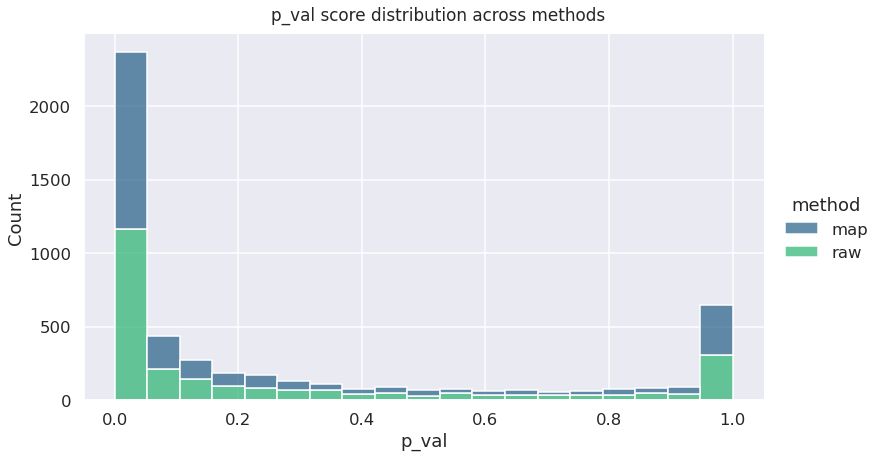

In [119]:
x_col = 'p_val'
plot_score_distribution(
    percantage_replicating_df,
    f"{x_col} score distribution across methods",
    'cellpainting_figures',
    'p_value_distribution_all.png',
    x='p_val'
)

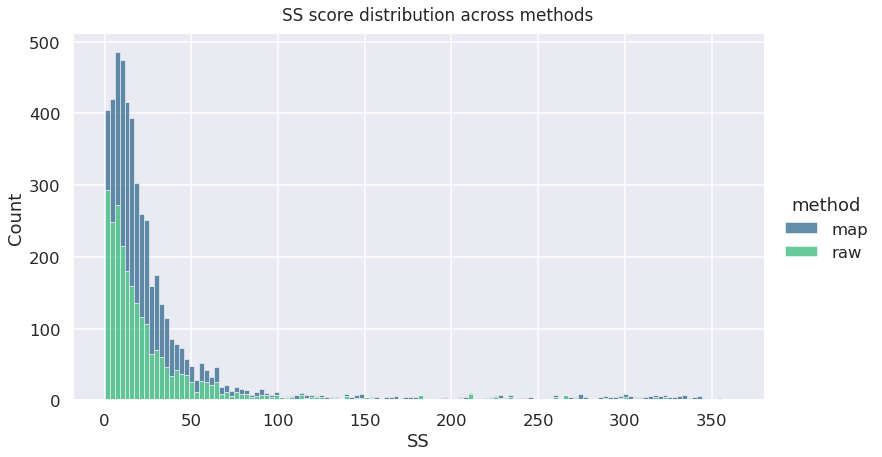

In [120]:
x_col = 'SS'
plot_score_distribution(
    percantage_replicating_df,
    f"{x_col} score distribution across methods",    
    'cellpainting_figures',
    'SS_score_distribution.png',
    x=x_col
)

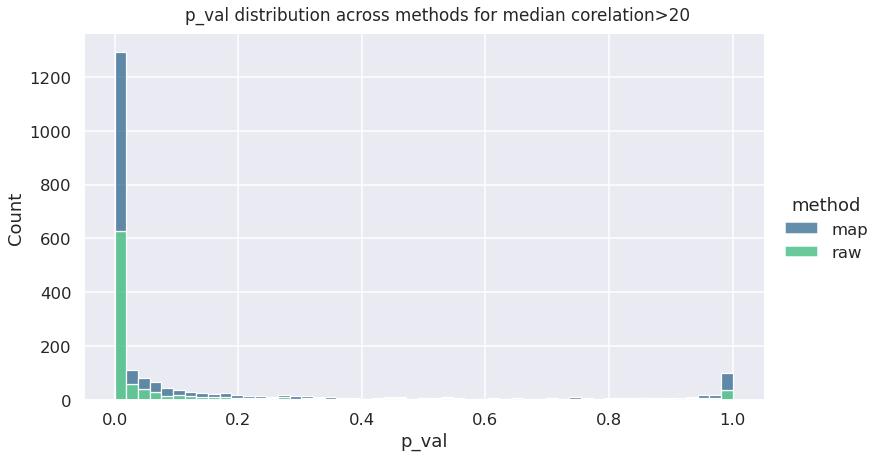

In [123]:
x = 'p_val'
median_threshold = 20
plot_score_distribution(
    percantage_replicating_df[percantage_replicating_df['SS']>median_threshold],
    f'p_val distribution across methods for median corelation>{median_threshold}',
    'cellpainting_figures',
    f'{x} stacked distribution for median corelation larger than {median_threshold}.png',
    x=x
)

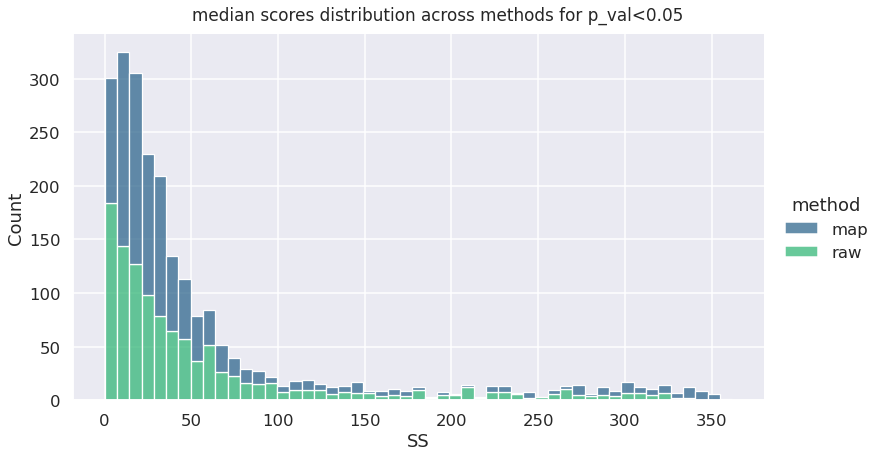

In [126]:
x='SS'
p_val_threshold = 0.05
plot_score_distribution(
    percantage_replicating_df[percantage_replicating_df['p_val']<p_val_threshold],
    f'median scores distribution across methods for p_val<{p_val_threshold}',
    'cellpainting_figures',
    f'{x}_stacked_distribution for p_val smaller than {p_val_threshold}.png',
    x=x
)


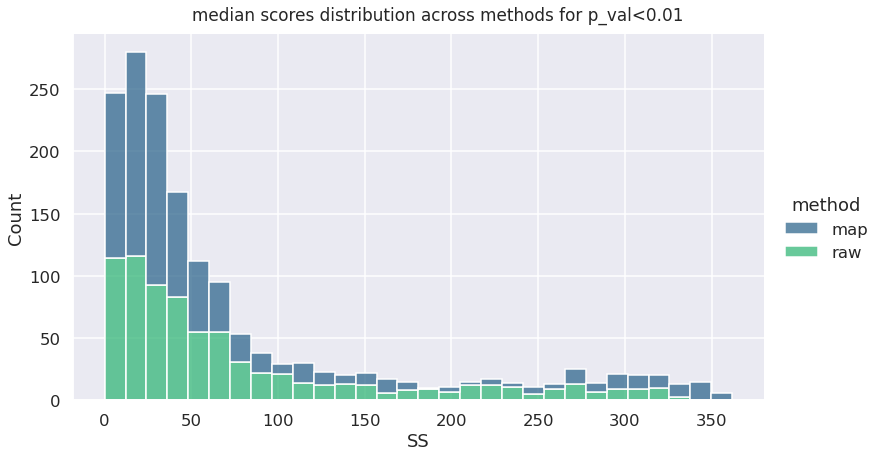

In [127]:
x='SS'
p_val_threshold = 0.01
plot_score_distribution(
    percantage_replicating_df[percantage_replicating_df['p_val']<p_val_threshold],
    f'median scores distribution across methods for p_val<{p_val_threshold}',
    'cellpainting_figures',
    f'{x}_stacked_distribution for p_val smaller than {p_val_threshold}.png',
    x=x
)

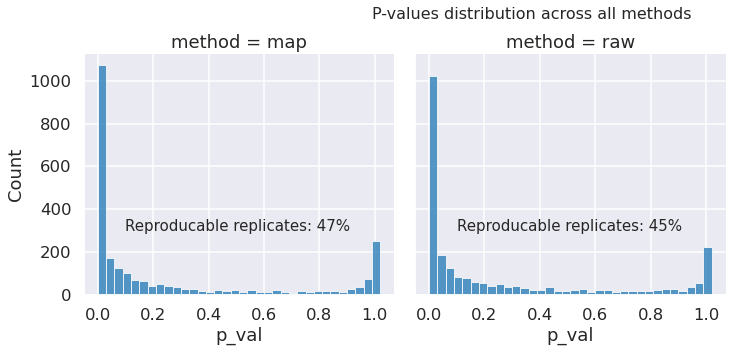

In [129]:
def plot_p_value_dist(df, path, file_name,thresh=0.05):
    """Plot p-values distribution"""
    if not os.path.exists(path):
        os.mkdir(path)  
    
    repr_score = {}
    methods = percantage_replicating_df.method.unique()
    for method in methods:
        df_method = percantage_replicating_df[percantage_replicating_df['method']==method]
        repr_score[method] = len(df_method[df_method['p_val']<=thresh])/ len(df_method)
    # repr_score
    dis_plt = sns.displot(df, x="p_val", col="method", col_wrap=3, binwidth=0.03)
    dis_plt.fig.suptitle("P-values distribution across all methods", size = 16)
    dis_plt.fig.subplots_adjust(top=.85)
    for ax, method in zip(dis_plt.axes.flat, methods):
        ax.text(0.1, 300,'Reproducable replicates: '+str(int(np.round(repr_score[method],2)*100))+'%', fontsize=15) #add text
    plt.savefig(os.path.join(path, file_name))
    plt.show()
    
plot_p_value_dist(percantage_replicating_df, 'cellpainting_figures', 'p_value_distribution_per_method.png',thresh=0.05)
repr_score = {}


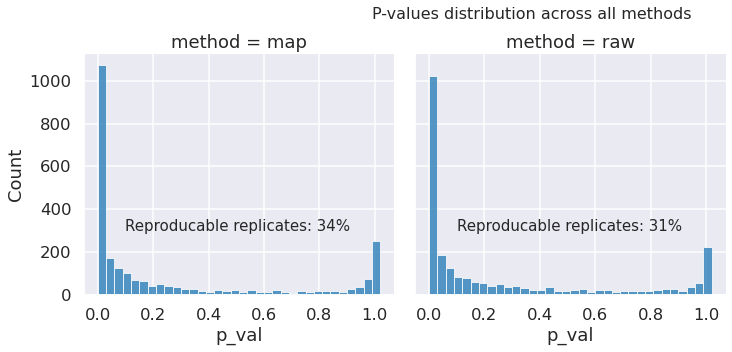

In [130]:
plot_p_value_dist(percantage_replicating_df, 'cellpainting_figures', 'p_value_distribution_per_method.png',thresh=0.01)
repr_score = {}

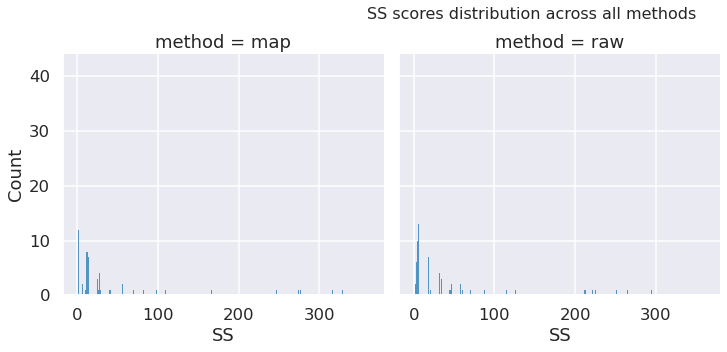

In [133]:
def plot_p_value_dist(df, path, file_name,x_col="fraction_score"):
    """Plot p-values distribution"""
    if not os.path.exists(path):
        os.mkdir(path)  
    dis_plt = sns.displot(df, x=x_col, col="method", col_wrap=3, binwidth=0.03)
    dis_plt.fig.suptitle(f"{x_col} scores distribution across all methods", size = 16)
    dis_plt.fig.subplots_adjust(top=.85)
    plt.savefig(os.path.join(path, file_name))
    plt.show()
                      
x_col="SS"
plot_p_value_dist(percantage_replicating_df, 'cellpainting_figures', f'{x_col}_score_distribution_per_method.png',x_col=x_col)

In [ ]:
def plot_p_value_dist(df, path, file_name,x_col="fraction_score", kind="kde"):
    """Plot p-values distribution"""
    if not os.path.exists(path):
        os.mkdir(path)  
    if kind=="kde":
        dis_plt = sns.displot(df, x=x_col, hue="method", kind=kind)
    elif kind=="hist":
        dis_plt = sns.histplot(df, x=x_col, hue="method",element="step", fill=False)
        # , multiple="dodge")
    elif kind == "ecdf":
        dis_plt = sns.ecdfplot(df, x=x_col, hue="method",stat="count", complementary=True)
    # dis_plt = sns.displot(df, x=x_col, col="method", col_wrap=3, binwidth=0.03)
    plt.title(f"{x_col} scores distribution across all methods", size = 16)
    plt.tight_layout()
    # dis_plt.subplots_adjust(top=.85)
    plt.savefig(os.path.join(path, file_name))
    plt.show()
                      
x_col="SS"
plot_p_value_dist(percantage_replicating_df, 
                  'cellpainting_figures', 
                  f'{x_col}_score_distribution_per_method.png',
                 kind="hist")

# ax = sns.barplot(x="day", y="total_bill", hue="sex", data=tips)

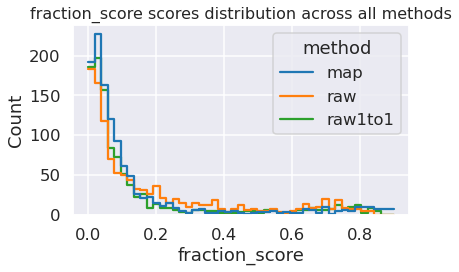

In [295]:
x='fraction_score'
p_val_threshold = 0.05
plot_p_value_dist(percantage_replicating_df[percantage_replicating_df['p_val']<p_val_threshold], 
                  'cellpainting_figures', 
                  f'{x_col}_score_distribution_per_method.png',
                 kind="hist")

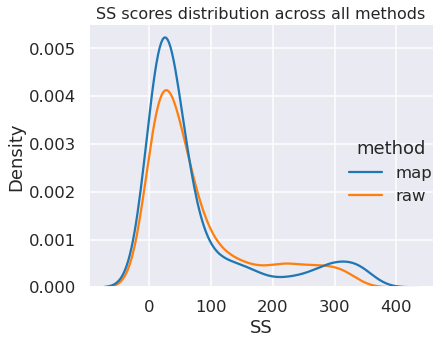

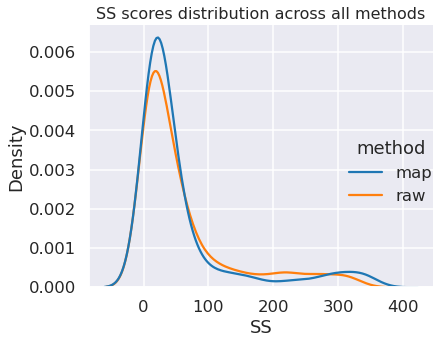

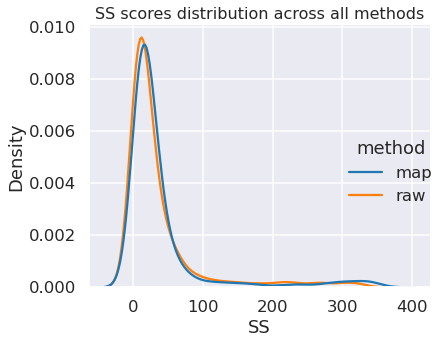

In [137]:
x='SS'

p_val_threshold = 0.01
plot_p_value_dist(percantage_replicating_df[percantage_replicating_df['p_val']<p_val_threshold], 
                  'cellpainting_figures', 
                  f'{x_col}_score_density for p_val smaller than {p_val_threshold}.png',
                 x_col=x)


p_val_threshold = 0.05
plot_p_value_dist(percantage_replicating_df[percantage_replicating_df['p_val']<p_val_threshold], 
                  'cellpainting_figures', 
                  f'{x_col}_score_density for p_val smaller than {p_val_threshold}.png',
                 x_col=x)

p_val_threshold = 1
plot_p_value_dist(percantage_replicating_df[percantage_replicating_df['p_val']<p_val_threshold], 
                  'cellpainting_figures', 
                  f'{x_col}_score_density for p_val smaller than {p_val_threshold}.png',
                 x_col=x)


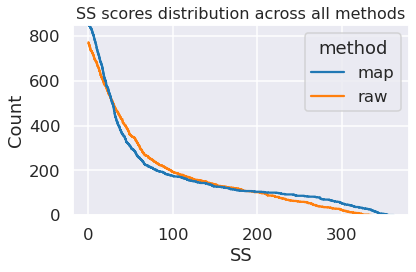

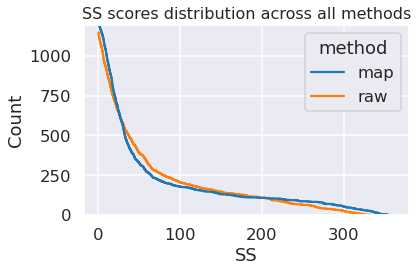

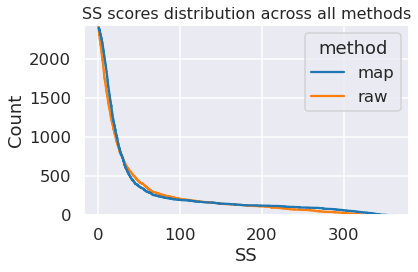

In [139]:
x='SS'

p_val_threshold = 0.01
plot_p_value_dist(percantage_replicating_df[percantage_replicating_df['p_val']<p_val_threshold], 
                  'cellpainting_figures', 
                  f'{x_col}_score ecdf for p_val smaller than {p_val_threshold}.png',
                 x_col=x
                  ,kind="ecdf")


p_val_threshold = 0.05
plot_p_value_dist(percantage_replicating_df[percantage_replicating_df['p_val']<p_val_threshold], 
                  'cellpainting_figures', 
                  f'{x_col}_score ecdf for p_val smaller than {p_val_threshold}.png',
                 x_col=x
                  ,kind="ecdf")

p_val_threshold = 1
plot_p_value_dist(percantage_replicating_df[percantage_replicating_df['p_val']<p_val_threshold], 
                  'cellpainting_figures', 
                  f'{x_col}_score ecdf for p_val smaller than {p_val_threshold}.png',
                 x_col=x
                  ,kind="ecdf")

In [205]:
# TODO
# 1. calc p-value for each cpd
# 2. plot graph
# 3. run for all plates
# 4. run on 1to1 and raw
# 4. add saving mechanisms
# 5. run for each scenario